В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [1]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [2]:
from sklearn.model_selection import train_test_split

df.drop('salary', axis=1, inplace=True) # удаляем признак, из-за которого возможен лик в данных, тк зарплата определяет таргет

X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

df2 = pd.get_dummies(df, drop_first=True)
df2 = df2.astype(int)

X = df2.drop('salary_in_usd', axis=1)
y = df2['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=False))

MAPE:  0.3920178072400022
RMSE:  49078.096764939786


c:\Users\BRIGPC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [4]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
import time

xgb = XGBRegressor()

params = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.05, 0.1]
}

xgb = XGBRegressor()

grid_search = GridSearchCV(xgb, param_grid=params, scoring='neg_mean_absolute_percentage_error', cv=3, n_jobs=-1)
grid_search.fit(X_val, y_val)

best_params = grid_search.best_params_

best_xgb = XGBRegressor(**best_params)
start_time = time.time()
best_xgb.fit(X_val, y_val)
training_time = time.time() - start_time

start_time = time.time()
y_pred = best_xgb.predict(X_val)
prediction_time = time.time() - start_time

print('Best params:', best_params)
print('MAPE:', mean_absolute_percentage_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared=False))
print('Training time:', training_time)
print('Prediction time:', prediction_time)

Best params: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
MAPE: 0.2925680748074468
RMSE: 42267.26634704362
Training time: 0.12602853775024414
Prediction time: 0.027005910873413086


c:\Users\BRIGPC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Качество модели с бустингом значительно улучшилось

In [5]:
!pip install catboost
from catboost import CatBoostRegressor

params = {
    'depth' : [3, 4, 5],
    'learning_rate' : [0.05, 0.1, 0.2],
    'iterations' : [100, 200, 300],
    'l2_leaf_reg' : [1, 2, 3],
    'bagging_temperature' : [0.1, 0.3, 0.5]
}

cb = CatBoostRegressor()

grid_search = GridSearchCV(cb, param_grid=params, scoring='neg_mean_absolute_percentage_error', cv=3, n_jobs=-1)
grid_search.fit(X_val, y_val)

best_params = grid_search.best_params_

best_cb = CatBoostRegressor(**best_params)
start_time = time.time()
best_cb.fit(X_val, y_val)
training_time = time.time() - start_time

start_time = time.time()
y_pred = best_cb.predict(X_val)
prediction_time = time.time() - start_time

print('Best params:', best_params)
print('MAPE:', mean_absolute_percentage_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared=False))
print('Training time:', training_time)
print('Prediction time:', prediction_time)


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\BRIGPC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\BRIGPC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\BRIGPC\AppData\Local\Programs\Python\Python312\Lib\site-packages\catboost\core.py", line 5827, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline

0:	learn: 62471.6991041	total: 146ms	remaining: 43.7s
1:	learn: 60531.2184119	total: 147ms	remaining: 21.9s
2:	learn: 59096.2193677	total: 147ms	remaining: 14.6s
3:	learn: 58178.4334271	total: 148ms	remaining: 10.9s
4:	learn: 56999.0910121	total: 148ms	remaining: 8.73s
5:	learn: 55872.8014745	total: 148ms	remaining: 7.27s
6:	learn: 55442.3193635	total: 149ms	remaining: 6.23s
7:	learn: 54697.8044382	total: 149ms	remaining: 5.44s
8:	learn: 54137.9971621	total: 150ms	remaining: 4.83s
9:	learn: 53693.9266335	total: 150ms	remaining: 4.35s
10:	learn: 53148.4805811	total: 150ms	remaining: 3.95s
11:	learn: 52974.2357753	total: 151ms	remaining: 3.61s
12:	learn: 52601.1088190	total: 151ms	remaining: 3.33s
13:	learn: 52460.6851050	total: 151ms	remaining: 3.09s
14:	learn: 52343.0404672	total: 152ms	remaining: 2.88s
15:	learn: 52203.9987221	total: 152ms	remaining: 2.7s
16:	learn: 52018.0369214	total: 152ms	remaining: 2.54s
17:	learn: 51735.8051978	total: 153ms	remaining: 2.39s
18:	learn: 51574.0933

c:\Users\BRIGPC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


ошибка уменьшилась, модель стала еще лучше, хорошая скорость предсказания и обучения

In [6]:
cat_features = list(df.select_dtypes(include=['object', 'category']).columns)

In [7]:
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [8]:
from catboost import Pool

params = {
    'depth' : [3, 4, 5],
    'learning_rate' : [0.05, 0.1, 0.2],
    'iterations' : [100, 200, 300],
    'l2_leaf_reg' : [1, 2, 3],
    'bagging_temperature' : [0.1, 0.3, 0.5]
}

cb = CatBoostRegressor()

X_train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
X_val_pool = Pool(X_val, label=y_val, cat_features=cat_features)

grid_search = GridSearchCV(cb, param_grid=params, scoring='neg_mean_absolute_percentage_error', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train, cat_features=cat_features)

best_params = grid_search.best_params_
best_cb = CatBoostRegressor(**best_params)

start_time = time.time()
best_cb.fit(X_train_pool)
training_time = time.time() - start_time

start_time = time.time()
y_pred = best_cb.predict(X_val_pool)
prediction_time = time.time() - start_time

print('Best params:', best_params)
print('MAPE:', mean_absolute_percentage_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared=False))
print('Training time:', training_time)
print('Prediction time:', prediction_time)

0:	learn: 60822.1859821	total: 19.3ms	remaining: 5.76s
1:	learn: 59164.3238265	total: 36.8ms	remaining: 5.48s
2:	learn: 57841.0763619	total: 55.2ms	remaining: 5.46s
3:	learn: 56702.3590335	total: 77.3ms	remaining: 5.72s
4:	learn: 55749.7608879	total: 96.8ms	remaining: 5.71s
5:	learn: 54948.1213417	total: 118ms	remaining: 5.77s
6:	learn: 53962.9587547	total: 140ms	remaining: 5.88s
7:	learn: 53196.2405830	total: 163ms	remaining: 5.93s
8:	learn: 52555.7138170	total: 183ms	remaining: 5.91s
9:	learn: 51902.7591854	total: 203ms	remaining: 5.88s
10:	learn: 51446.4490231	total: 215ms	remaining: 5.64s
11:	learn: 50926.1534960	total: 234ms	remaining: 5.62s
12:	learn: 50536.8059901	total: 254ms	remaining: 5.61s
13:	learn: 50145.1650265	total: 275ms	remaining: 5.62s
14:	learn: 49803.4160169	total: 297ms	remaining: 5.64s
15:	learn: 49478.0100899	total: 316ms	remaining: 5.61s
16:	learn: 49229.1620654	total: 340ms	remaining: 5.66s
17:	learn: 49043.9002757	total: 364ms	remaining: 5.7s
18:	learn: 48866

c:\Users\BRIGPC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


ошибки увеличились, время обучения увеличилось, однако время предсказания уменьшилось, но в общем стало скорее хуже

In [9]:
X = df2.drop('salary_in_usd', axis=1)
y = df2['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [10]:
from lightgbm import LGBMRegressor

params = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'num_leaves': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0]
}

LGBM = LGBMRegressor()

grid_search = GridSearchCV(LGBM, param_grid=params, scoring='neg_mean_absolute_percentage_error', cv=3, n_jobs=-1)
grid_search.fit(X_val, y_val)

best_params = grid_search.best_params_

best_LGBM = LGBMRegressor(**best_params)
start_time = time.time()
best_cb.fit(X_val, y_val)
training_time = time.time() - start_time

start_time = time.time()
y_pred = best_cb.predict(X_val)
prediction_time = time.time() - start_time

print('Best params:', best_params)
print('MAPE:', mean_absolute_percentage_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared=False))
print('Training time:', training_time)
print('Prediction time:', prediction_time)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 376, number of used features: 14
[LightGBM] [Info] Start training from score 141216.609043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

c:\Users\BRIGPC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1.   CatBoostRegressor (без pool) показал лучший результат по MAPE и RMSE, LightGBM оказался на втором месте
2.   скорость предсказания была наиболее высокой у CatBoostRegressor с использованием pool, но он показал худший результат по качеству и веремени обучения
3.   LightGBM и XGBRegressor показали сопоставимые результаты по качеству и времени работы
4.  лучший результат по времени обучения - XGBRegressor
5. CatBoostRegressor (без pool) обучается дольше остальных бустингов

таким образом для наших данных, если мы больше ориентируемся на минимизацию ошибки - выбираем CatBoostRegresso, минимизируем скорость обучения - XGBRegressor,  предсказания - CatBoostRegressor (без pool), LightGBM тоже показал хорошие результаты по всем показателям

Отличия в гиперпараметрах:
1. CatBoostRegressor имеет параметры bagging_temperature (интенсивность бэггинга) и l2_leaf_reg (регуляризация), LightGBM имеет параметр num_leaves (количество листьев), которые отсутствуют в других моделях (XGBRegressor тоже имеет другие параметры но мы их не использовали, у остальных моделей тоже есть другие)
2. из одинаковых для всех моделей параметров - learning_rate = 0.05 для LightGBM и XGBRegressor, у остальных другой
3. у двух моделей CatBoostRegressor совпадают парметры bagging_temperature, iterations, остальные отличаются
4. для LightGBM и XGBRegressor max_depth одинаковый, n_estimators разные

таким образом, модели достаточно сильно отличаются по гиперпараметрам


Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [11]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [12]:
transposed_ratings = ratings.T
transposed_ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
transposed_ratings = transposed_ratings.drop('user')

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [14]:
ratings = transposed_ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
matt pond pa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028416


In [15]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters = 5,  random_state=0)
k_means = k_means.fit(ratings)
clusters = k_means.predict(ratings)

In [16]:
import numpy as np

cluster_sizes = np.bincount(clusters)
print(cluster_sizes)

[  1   1   2 995   1]


Кластеризация получилась бесполезной, в одном кластере у нас находится 99,6% от всех наблюдений, в остальных четырех кластерах только по одному наблюдению, данные не были разделены на осмысленные кластеры. Такое может произойти, так как метод к-средних не способен выделять кластеры сложных форм из-за принципа действия своего алгоритма, чувствителен к выбросам, хорошо работает только с линейно разделимыми данными и требует изначального знания количества кластеров (мы не убедились, что 5 - оптимальное значение количества кластеров). наличие нулей вместо пропусков сбивает среднее значение, возможно, стоит нормализовать данные


In [17]:
cluster_indices = {} # словарь для каждого кластера
for cluster_num in range(5):
    indices = [index for index, cluster in enumerate(clusters) if cluster == cluster_num]
    cluster_indices[cluster_num] = indices

single_artist_clusters = [index for index, cluster in cluster_indices.items() if len(cluster) == 1 ]
for cluster_num in single_artist_clusters:
    artist_index = cluster_indices[cluster_num][0]
    artist_name = ratings.index[artist_index]
    print(artist_name)

nickel creek
junior boys
judas priest


         Average number of listeners  Average listening
Cluster                                                
0                          79.000000           0.000702
1                          69.000000           0.000523
2                         116.500000           0.001367
3                         134.309548           0.000993
4                         112.000000           0.001517


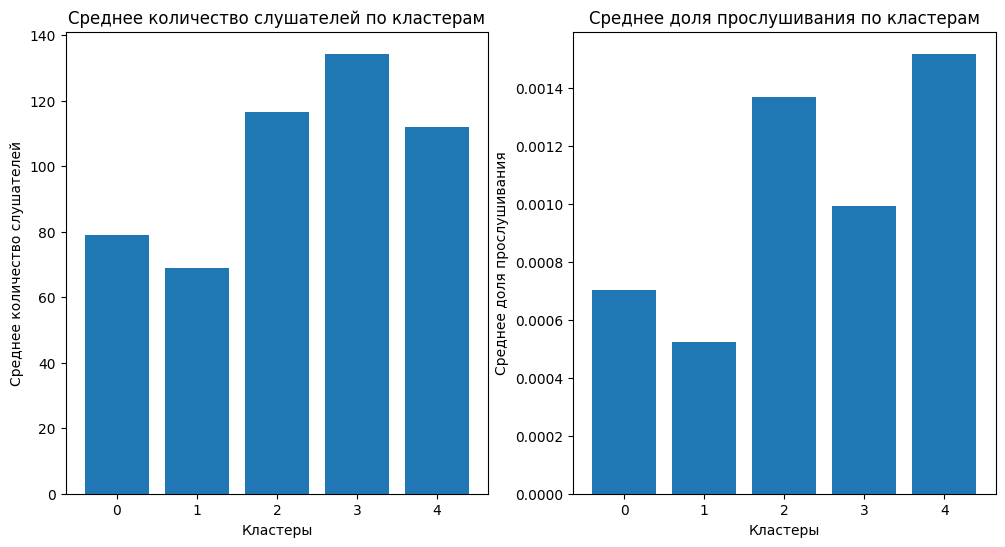

Название исполнителя во 2 кластере: tori amos


In [18]:
import matplotlib.pyplot as plt
clusters = k_means.labels_

# подсчет числа слушателей и средней доли прослушивания для каждого исполнителя
def num_of_listeners_and_av_listening(ratings):
    num_of_listeners = (ratings > 0).sum(axis=1)
    average_listening = ratings.mean(axis=1)
    return num_of_listeners, average_listening

num_of_listeners, average_listening = num_of_listeners_and_av_listening(ratings)

# доля слушателей и средней доли прослушивания для каждого кластера
def analyze_clusters(clusters, num_of_listeners, average_listening):
    cluster_info = pd.DataFrame({
        'Average number of listeners': num_of_listeners,
        'Average listening': average_listening,
        'Cluster': clusters
    })
    cluster_summary = cluster_info.groupby('Cluster').mean() # расчет среднего числа слушателей и средней доли прослушивания по кластерам
    return cluster_summary

cluster_summary = analyze_clusters(clusters, num_of_listeners, average_listening)
print(cluster_summary)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(cluster_summary.index, cluster_summary['Average number of listeners'])
plt.title('Среднее количество слушателей по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Среднее количество слушателей')

plt.subplot(1, 2, 2)
plt.bar(cluster_summary.index, cluster_summary['Average listening'])
plt.title('Среднее доля прослушивания по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Среднее доля прослушивания')

plt.show()

artist_index = cluster_indices[2][0]
artist_name = ratings.index[artist_index]
print(f"Название исполнителя во 2 кластере: {artist_name}")

**Ответ:** The Beatles является самым популярным исполнителем, у них резко выделяется количество слушателей и доля прослушивания (сравнение со средним количеством прослушивания по кластерам)

In [19]:
from sklearn.preprocessing import normalize

normalized_ratings = normalize(ratings)

In [20]:
k_means = KMeans(n_clusters = 5, random_state=0)
k_means = k_means.fit(normalized_ratings)
clusters = k_means.predict(normalized_ratings)
cluster_sizes = np.bincount(clusters)

In [21]:
print(cluster_sizes)

[198 279 140 254 129]


In [22]:
for i in cluster_sizes:
    print(f'Доля наблюдений, находящихся в {list(cluster_sizes).index(i)+1} кластере: {i/sum(cluster_sizes)}')

Доля наблюдений, находящихся в 1 кластере: 0.198
Доля наблюдений, находящихся в 2 кластере: 0.279
Доля наблюдений, находящихся в 3 кластере: 0.14
Доля наблюдений, находящихся в 4 кластере: 0.254
Доля наблюдений, находящихся в 5 кластере: 0.129


Кластеризация оказалось полезной, размеры кластеров стали адекватными, теперь кластеризация может быть полезной





In [23]:
normalized_ratings = pd.DataFrame(data=normalized_ratings, columns=ratings.columns)
normalized_ratings = normalized_ratings.set_index(ratings.index)
normalized_ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [24]:
from scipy.spatial.distance import cosine

centroids = k_means.cluster_centers_

for i in range(5):
    print(f"Кластер {i+1}:")
    cluster_artists = normalized_ratings.index[clusters == i]

    distances = []
    for artist in cluster_artists:
        artist_vector = normalized_ratings.loc[artist].values
        distance = cosine(artist_vector, centroids[i])
        distances.append((artist, distance))

    distances.sort(key=lambda x: x[1])
    top_10_artists = [artist for artist, _ in distances[:10]]
    for i in range(10):
      print(f"{i+1}) {top_10_artists[i]}")
    print()

Кластер 1:
1) the beatles
2) coldplay
3) the rolling stones
4) dylan. bob
5) u2
6) led zeppelin.
7) counting crows
8) johnson jack
9) simon and garfunkel
10) eric clapton

Кластер 2:
1) a tribe called quest
2) nas
3) the roots featuring d'angelo
4) ￼beastie boys
5) niИ
6) gangstarr
7) ratm
8) jay-z
9) de la soul
10) tool

Кластер 3:
1) fall out boy
2) blink-182
3) taking back sunday
4) brand new
5) saosin
6) the used
7) new found glory
8) cartel
9) chiodos
10) paramore

Кластер 4:
1) radiohead
2) the arcade fire
3) sufjan stevens
4) belle and sebastian
5) broken social scene
6) animal collective
7) the shins
8) of montreal
9) beirut
10) spoon

Кластер 5:
1) rihanna & jay-z
2) the pussycat dolls
3) janet jackson.
4) mariah carey
5) kelly clarkson
6) alicia keys
7) beyoncé
8) justin timberlake
9) kanye west
10) lady gaga



Кластеры могут быть интерпретированы как музыкальные жанры:
кластер 1 - альтернативный рок или панк-рок;
кластер 2 - хип-хоп;
кластер 3 - инди-рок и альтернативная музыка;
кластер 4 - эмо и поп-панк;
кластер 5 - поп-рок.



C:\Users\BRIGPC\AppData\Local\Temp\ipykernel_1628\626659005.py:17: UserWarning: Glyph 26893 (\N{CJK UNIFIED IDEOGRAPH-690D}) missing from current font.
  plt.tight_layout()
C:\Users\BRIGPC\AppData\Local\Temp\ipykernel_1628\626659005.py:17: UserWarning: Glyph 26494 (\N{CJK UNIFIED IDEOGRAPH-677E}) missing from current font.
  plt.tight_layout()
C:\Users\BRIGPC\AppData\Local\Temp\ipykernel_1628\626659005.py:17: UserWarning: Glyph 20280 (\N{CJK UNIFIED IDEOGRAPH-4F38}) missing from current font.
  plt.tight_layout()
C:\Users\BRIGPC\AppData\Local\Temp\ipykernel_1628\626659005.py:17: UserWarning: Glyph 22827 (\N{CJK UNIFIED IDEOGRAPH-592B}) missing from current font.
  plt.tight_layout()
C:\Users\BRIGPC\AppData\Local\Temp\ipykernel_1628\626659005.py:17: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missing from current font.
  plt.tight_layout()
C:\Users\BRIGPC\AppData\Local\Temp\ipykernel_1628\626659005.py:17: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from current font.


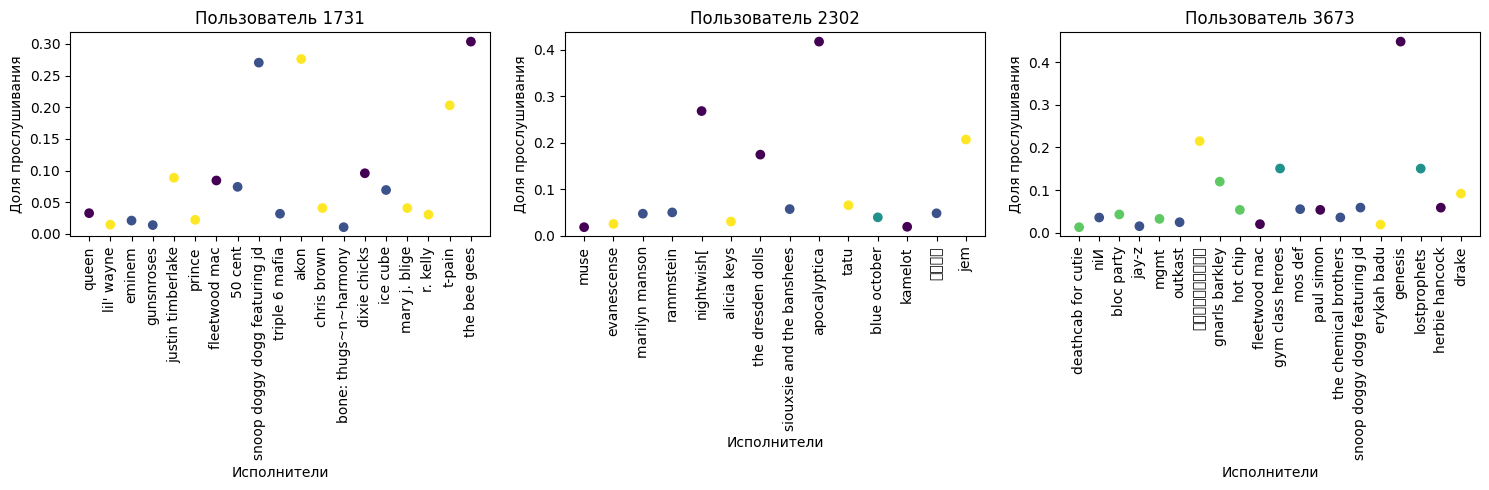

In [25]:
random_users = np.random.choice(normalized_ratings.columns, 3, replace=False)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, user in enumerate(random_users):
    user_ratings = normalized_ratings[user]
    nonzero_ratings = user_ratings[user_ratings > 0] #отбираем ненулевые доли прослушивания
    nonzero_clusters = clusters[user_ratings > 0]

    axs[i].scatter(nonzero_ratings.index, nonzero_ratings.values, c=nonzero_clusters, cmap='viridis')
    axs[i].set_xticks(range(len(nonzero_ratings)))
    axs[i].set_xticklabels(nonzero_ratings.index, rotation=90)
    axs[i].set_ylabel('Доля прослушивания')
    axs[i].set_xlabel('Исполнители')
    axs[i].set_title(f'Пользователь {user}')

plt.tight_layout()
plt.show()

Просмотрев несколько троек слушателей, я заметила, что у некоторых пользователей (4216 например) преобладает какой-то кластер, скорее всего, определенный человек предпочитает какой то жанр, у некоторых же распределение по кластеров плюс минус равное, видимо, они слушают разные жанры, у многих явно видно артиста с наибольшей долей прослушивания - это любимый исполнитель. эти графики подтверждают осмысленность разделения на кластеры

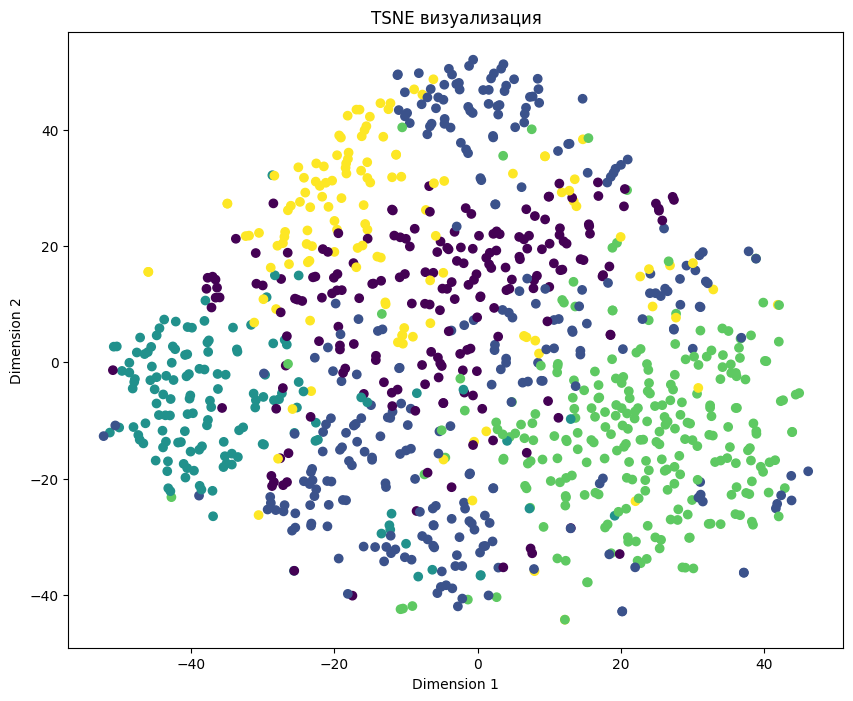

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(normalized_ratings)

tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Cluster'], cmap='viridis', label=clusters)
plt.title('TSNE визуализация')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [27]:
from sklearn.metrics import silhouette_score

max_clusters = 100
silhouette_scores = []

for n_clusters in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(normalized_ratings)
    clusters = kmeans.predict(normalized_ratings)
    silhouette_avg = silhouette_score(normalized_ratings, clusters)
    silhouette_scores.append(silhouette_avg)

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"\nОптимальное количество кластеров: {optimal_clusters}")


Оптимальное количество кластеров: 84


In [28]:
k_means = KMeans(n_clusters=95, random_state=42)
k_means.fit(normalized_ratings)
clusters = k_means.predict(normalized_ratings)
centroids = k_means.cluster_centers_

for i in range(95):
    print(f"Кластер {i+1}:")
    cluster_artists = normalized_ratings.index[clusters == i]

    distances = []
    for artist in cluster_artists:
        artist_vector = normalized_ratings.loc[artist].values
        distance = cosine(artist_vector, centroids[i])
        distances.append((artist, distance))

    distances.sort(key=lambda x: x[1])
    top_5_artists = [artist for artist, _ in distances[:5]]
    if len(top_5_artists) >= 5:  # условие тк в некоторых кластерах мало исполнителей, 5 для более простого анализа
      print(*top_5_artists[0:5], sep=', ')
    else:
      print(*top_5_artists, sep=', ')
    print()

Кластер 1:
dr. dre, the faint, violent femmes, margot and the nuclear so and sos, owen

Кластер 2:
john mayer, matt nathanson, gavin degraw, jason mraz, ray lamontagne

Кластер 3:
white stripes, beck, the raconteurs, spoon, the pixies

Кластер 4:
fugazi, jawbreaker, sleater-kinney, les savy fav, bad brains

Кластер 5:
ryan adams, band of horses, ryan adams and the cardinals, rogue wave, my morning jacket

Кластер 6:
dj shadow, rjd2, ￼beastie boys, amon tobin, jedi mind tricks

Кластер 7:
system of a down, koЯn, mudvayne, limpt bizkit, disturbed

Кластер 8:
somethings corporate, the rocket summer, jack’s mannequin, cartel, the format

Кластер 9:
chiodos, underoath, scary kids scaring kids, saosin, norma jean

Кластер 10:
the police, peter gabriël, r.e.m., bush, sade

Кластер 11:
j dilla, the loopdigga, mf doom & madlib as madvillain, a tribe called quest, quasimoto

Кластер 12:
alicia keys, mary j. blige, aaliyah, janet jackson., destinys child

Кластер 13:
sufjan stevens, the arcade fi

In [29]:
for i in [59, 87]:
    print(f"Кластер {i+1}:")
    cluster_artists = normalized_ratings.index[clusters == i]

    distances = []
    for artist in cluster_artists:
        artist_vector = normalized_ratings.loc[artist].values
        distance = cosine(artist_vector, centroids[i])
        distances.append((artist, distance))

    distances.sort(key=lambda x: x[1])
    top_5_artists = [artist for artist, _ in distances[:5]]
    if len(top_5_artists) >= 5:
      print(*top_5_artists[0:5], sep=', ')
    else:
      print(*top_5_artists, sep=', ')
    print()

Кластер 60:
the libertines, bloc party, patrick wolf, the editors, the fratellis

Кластер 88:
t.i., lil' wayne, ross, rick, jay-z, ludacris



В 60 кластере находятся исполнители классической музыки (вроде единственный такой кластер), в 88 - рэп исполнители (в 17 тоже рэп, но другого настроения)

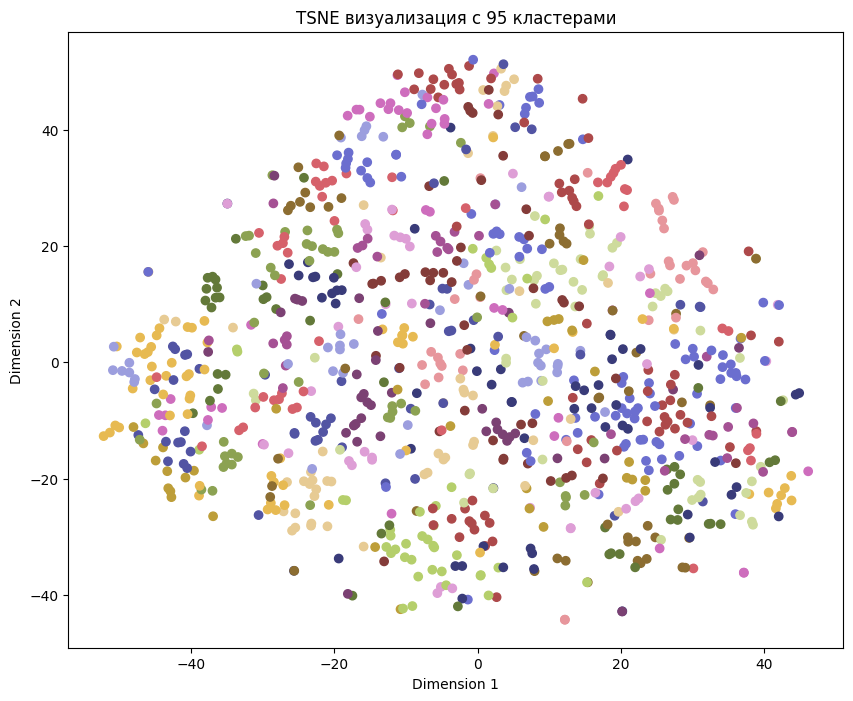

In [30]:
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(normalized_ratings)

tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Cluster'], cmap='tab20b', label=clusters)
plt.title('TSNE визуализация с 95 кластерами')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

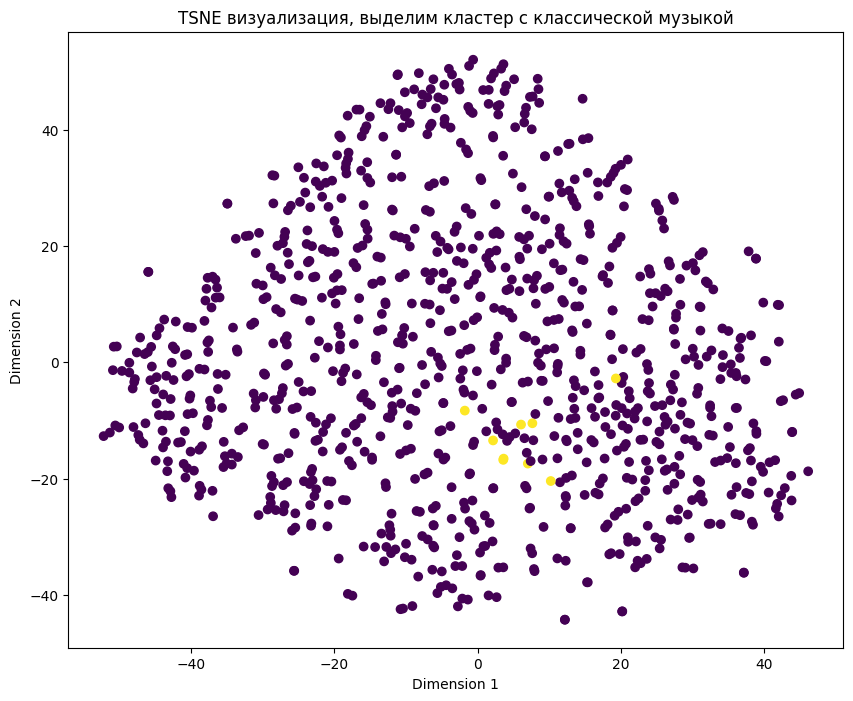

In [31]:
tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c = (clusters == 59), cmap='viridis', label=clusters)
plt.title('TSNE визуализация, выделим кластер с классической музыкой')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Кластер с классической музыкой достаточно хорошо отделился в визуализации, скорее всего, потому что он достаточно сильно отличается от остальных, что подтверждает хороший результат кластеризации